In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import xgboost as xgb
import sklearn as skl
import sklearn.datasets as skl_data
from sklearn.inspection import DecisionBoundaryDisplay

import time
import json

from mylib import class_distributions
from mylib import data_selection
from mylib import helper_funcs

from mylib.my_xgb import BinaryDecisionTree as BDT
from mylib.my_xgb import add_class
from mylib.my_xgb import loss_functions

import dtreeviz
import logging
# to suppress messages when plotting trees
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

%load_ext autoreload
%autoreload 2

In [3]:
image_folder = Path("../../../images/")

In [4]:
"""
Basic Binary Decision Tree Class.
"""

import numpy as np
import pandas as pd

import time
from numba import njit 
from queue import Queue

from mylib.my_xgb import loss_functions


class Node:
    
    def __init__(self, left=None, right=None, parent=None, split_feat=0, split_val=None,
                 leaf_val=None, base_weight=None, default_left=1, gain=None,
                 cover=None, node_id = None):
        
        self.left = left
        self.right = right
        self.parent = parent
        self.split_feat = split_feat
        self.split_val = split_val   # only if Node is inner Node
        self.leaf_val = leaf_val     # only if Node is a leaf
        self.base_weight = base_weight
        self.default_left = default_left
        self.gain = gain
        self.cover = cover
        self.node_id = node_id
        

class BinaryDecisionTree:
    
    def __init__(self, root=None, class_label=None, num_features=None, **params):
        
        # set min_child_weight=0 for simplicity. The default of XGBoost is 1 !
        # for now this means that I don't need to check the stopping criterion induced by min_child_weight
        
        """
        Parameters:
            root (Node)             : root of the tree
            class_label (int)       : index of the class to be learned (0-based)
            num_features (int)      : number of features
            params (dict)           : Parameters
                max_depth (int)         : max_depth as specified for XGBoost
                eta (float)             : learning rate
                min_child_weight (float): minimum Cover that the children in a split need for that split to happen
                                          otherwise next best split is taken [NOT IMPLEMENTED]
                gamma (float)           : minimum gain required for a split to happen
                lamb (float)            : hyperparameter used in calculations
        """
        
        # I don't know whats going on here ...
        params = params['params']
        
        self.root = root
        self.class_label = class_label
        self.num_features = num_features
        
        self.max_depth = params.get('max_depth', 10)
        self.eta = params.get('eta', 1)
        self.min_child_weight = params.get('min_child_weight', 0)
        self.gamma = params.get('gamma', 0)
        self.lam = params.get('lam', 1)
        
    def fit(self, features, labels, previous_prediction, weights=None):
        """
        Fits a tree.
        
        Parameters:
            features (np.ndarray or pd.DataFrame): the data without labels
            labels (np.ndarray or pd.Series)     : the labels
            previous_prediction (np.ndarray)     : previous prediction of the current model
            weights (np.ndarray)                 : weights for gradient and hessian
        """
        
        if isinstance(features, pd.DataFrame):
            features = features.to_numpy()
        if isinstance(labels, pd.DataFrame) or isinstance(labels, pd.Series):
            labels = labels.to_numpy()
        
        assert isinstance(previous_prediction, np.ndarray)
        
        if isinstance(features, np.ndarray) and isinstance(labels, np.ndarray):
            
            # computes gradient statistics
            grad, hess = softprob_obj(features, labels, previous_prediction, weights)

            self.root = self._grow_tree(features, labels, grad, hess)
            
            # create node_ids in a BFS-manner
            self._create_node_ids()
            # create parent ids
            self._create_parent_ids()
              
        else:
            print("features and labels should have datatype np.ndarray or pd.Dataframe.")
            return
    

    def _grow_tree(self, features, labels, grad, hess, depth=0):
        """
        Grows a tree for given features and labels. The depth where the tree's root is at, is passed as an argument.
        """
        
        best_split_feature, best_split_value, max_gain, cover = _calc_best_split(features=features,
                                                                                 labels=labels,
                                                                                 grad=grad,
                                                                                 hess=hess,
                                                                                 class_label=self.class_label,
                                                                                 lam=self.lam)
        base_weight = self._calc_base_weight(grad, hess)
        
        # check stopping criteria
        if self._stopping_criteria(depth, max_gain):
            leaf_value, cover = self._calc_leaf_value(grad, hess)
            base_weight = self._calc_base_weight(grad, hess)
            return Node(split_val=leaf_value,
                        leaf_val=leaf_value,
                        base_weight=base_weight,
                        default_left=0,
                        gain=leaf_value,
                        cover=cover)
        
        left_idx, right_idx = self._split(features, best_split_feature, best_split_value)
        
        left  = self._grow_tree(features[left_idx],  labels[left_idx],  grad[left_idx],  hess[left_idx],  depth+1)
        right = self._grow_tree(features[right_idx], labels[right_idx], grad[right_idx], hess[right_idx], depth+1)
        
        return Node(left=left, right=right, split_feat=best_split_feature, split_val=best_split_value,
                    base_weight=base_weight, default_left=1, gain=max_gain, cover=cover)
    
    
    def _split(self, features, split_feature, split_value):
        """
        Splits features according to split_feature and split_value.
        """
        left_idx  = np.argwhere(features[:, split_feature] <  split_value).flatten()
        right_idx = np.argwhere(features[:, split_feature] >= split_value).flatten()
        
        return left_idx, right_idx
    

    def _calc_leaf_value(self, grad, hess):
        """
        Calculates a leaf value.
        """
        G = grad[:, self.class_label].sum()
        H = hess[:, self.class_label].sum()
        leaf_value = -self.eta*(G/(H+self.lam))
        cover = H
        
        return leaf_value, cover
    
    
    def _calc_base_weight(self, grad, hess):
        """
        Calculates the base weight of a node. This is basically the leaf value
        that this node would have, but without regard for the learning rate.
        """
        
        G = grad[:, self.class_label].sum()
        H = hess[:, self.class_label].sum()
        base_weight = -G/(H+self.lam)
        
        return base_weight
        
        
    def _stopping_criteria(self, depth, max_gain):
        """
        Implements stopping criteria. Returns True if growing should stop.
        """
        if depth >= self.max_depth:
            return True
        if max_gain < self.gamma:
            return True

        return False

    
    def _create_node_ids(self):
        """
        Gives the tree-nodes IDs in BFS-order.
        """
        
        if self.root==None:
            return
        
        Q=Queue()
        Q.put(self.root)
        ID = 0
        
        while(not Q.empty()):
            node=Q.get()
            if node is None:
                continue
                
            node.node_id = ID
            ID = ID+1
        
            Q.put(node.left)
            Q.put(node.right)
        
        
    def _create_parent_ids(self):
        """
        Assigns parent pointers to nodes.
        """
        
        if self.root==None:
            return
        
        Q=Queue()
        Q.put((self.root, None))
        
        while(not Q.empty()):
            node, parent = Q.get()
            if node is None:
                continue
            
            node.parent = parent
            Q.put((node.left, node))
            Q.put((node.right, node))
           
        
    def _calc_num_nodes(self):
        """
        Counts number of nodes in a tree.
        """
        
        count = 0
        
        if self.root==None:
            return count
        
        Q=Queue()
        Q.put(self.root)
        
        while(not Q.empty()):
            node=Q.get()
            if node is None:
                continue
            
            count = count + 1
        
            Q.put(node.left)
            Q.put(node.right)
        
        return count
    
    
    def tree_to_dataframe(self):
        """
        Writes information in tree into a pd.DataFrame.
        """
        
        if self.root==None:
            return
        
        Q=Queue()
        Q.put(self.root)
        ID = 0
        
        rows_list = []
        
        while(not Q.empty()):
            node=Q.get()
            if node is None:
                continue
            
            new_row = {}
            new_row['Node'] = ID
            ID = ID+1
            
            if node.split_feat is None:
                new_row['Feature'] = 'Leaf'
            else:
                new_row['Feature'] = node.split_feat
                
            new_row['Split'] = node.split_val
            new_row['Gain'] = node.gain
            new_row['Base Weight'] = node.base_weight
            new_row['Cover'] = node.cover
            new_row['Default left'] = node.default_left
            new_row['node_id'] = node.node_id
            if node.parent is not None:
                new_row['parent'] = node.parent.node_id
            else:
                new_row['parent'] = 2147483647
            
            rows_list.append(new_row)
            
            Q.put(node.left)
            Q.put(node.right)
            
        tree_df = pd.DataFrame(rows_list)
        
        return tree_df
    
    
    def to_xgboost_dict(self):
        """
        Creates a dictionary as XGBoost does for each tree.
        """
        
        tree_dict = {}
        
        base_weights = []
        categories = []
        categories_nodes = []
        categories_segments = []
        categories_sizes = []
        default_left = []
        tree_id = 0
        left_children = []
        loss_changes = []
        parents = []
        right_children = []
        split_conditions = []
        split_indices = []
        split_type = []
        sum_hessian = []
        tree_param = {}

        
        if self.root==None:
            return
        
        Q=Queue()
        Q.put(self.root)
        
        while(not Q.empty()):
            node=Q.get()
            if node is None:
                continue
                
            # base weights
            base_weights.append(round(node.base_weight,8))
            # default left
            default_left.append(node.default_left)
            
            # left_children
            if node.left is not None:
                left_children.append(node.left.node_id)
            else:
                left_children.append(-1)
                
            # loss_changes
            if node.leaf_val is None:  #if it's not a leaf
                loss_changes.append(round(node.gain, 8))
            else:
                loss_changes.append(0.0)
                
            # parents
            if node.parent is not None:
                parents.append(node.parent.node_id)
            else:
                parents.append(2147483647)
            
            # right_children
            if node.right is not None:
                right_children.append(node.right.node_id)
            else:
                right_children.append(-1)
                
            # split conditions
            split_conditions.append(round(node.split_val, 8))
            # split_indices
            split_indices.append(node.split_feat)
            # split_type
            split_type.append(0)
            # sum_hessian
            sum_hessian.append(round(node.cover, 8))
            
            # tree param
            tree_param['num_deleted'] = '0'   # seems to always be 0
            tree_param['num_feature'] = str(self.num_features)
            tree_param['num_nodes'] = str(self._calc_num_nodes())
            tree_param['size_leaf_vector'] = '0'   # also seems to always be 0
            
            Q.put(node.left)
            Q.put(node.right)
            
        tree_dict['base_weights'] = base_weights
        
        #these are all empty
        tree_dict['categories'] = categories
        tree_dict['categories_nodes'] = categories_nodes
        tree_dict['categories_segments'] = categories_segments
        tree_dict['categories_sizes'] = categories_sizes
        
        tree_dict['default_left'] = default_left
        tree_dict['id'] = tree_id   # i will reset these later
        tree_dict['left_children'] = left_children
        tree_dict['loss_changes'] = loss_changes
        tree_dict['parents'] = parents
        tree_dict['right_children'] = right_children
        tree_dict['split_conditions'] = split_conditions
        tree_dict['split_indices'] = split_indices
        tree_dict['split_type'] = split_type
        tree_dict['sum_hessian'] = sum_hessian
        tree_dict['tree_param'] = tree_param
        
        return tree_dict
    

@njit
def _calc_best_split(features, labels, grad, hess, class_label, lam):
    """
    Calculates best split for given features, labels and loss statistics.
    """

    num_samples, num_features = features.shape

    best_gain = -np.inf
    best_split_feature = None
    best_split_value = None


    # these are always the same
    G_root = grad[:, class_label].sum()
    H_root = hess[:, class_label].sum()

    for split_feature in range(num_features):
        sorted_feature_ids = features[:, split_feature].argsort()
        G_left = 0
        H_left = 0

        for split_index in range(1, num_samples):
            G_left += grad[sorted_feature_ids[split_index-1], class_label]
            H_left += hess[sorted_feature_ids[split_index-1], class_label]

            G_right = G_root - G_left
            H_right = H_root - H_left

            current_gain = _calc_split_gain(G_root, H_root, G_left, H_left, G_right, H_right, lam)

            print(split_feature, split_index)
            print(G_left, G_right, H_left, H_right)
            print(current_gain)
            
            if current_gain > best_gain:
                best_gain = current_gain
                best_split_feature = split_feature
                best_split_value = _calc_split_val(features,
                                                        sorted_feature_ids,
                                                        split_index,
                                                        split_index-1,
                                                        split_feature)
        
    return best_split_feature, best_split_value, best_gain, H_root
    
    
@njit
def _calc_split_gain(G_root, H_root, G_left, H_left, G_right, H_right, lam):
    """
    For given statistics calculates the gain.
    """

    return _calc_term(G_left, H_left, lam) + _calc_term(G_right, H_right, lam) - _calc_term(G_root, H_root, lam)
    
    
@njit
def _calc_term(g, h, lam):
    """
    Calculates a term.
    """
    print("Term: ", np.square(g) / (h + lam))
    return np.square(g) / (h + lam)
    
    
@njit
def _calc_split_val(features, sorted_feature_ids, split_index1, split_index2, split_feature):
    """
    For a given split_index and split_feature calculates the split_value that XGBoost would use
    (always the midpoints between the values).
    """

    split_val1 = features[sorted_feature_ids[split_index1]][split_feature]
    split_val2 = features[sorted_feature_ids[split_index2]][split_feature]

    return (split_val1+split_val2)/2

In [42]:
def plot_decision_boundaries(data, labels, model):
    feature_1, feature_2 = np.meshgrid(
    np.linspace(data.to_numpy()[:, 0].min()-1, data.to_numpy()[:, 0].max()+1),
    np.linspace(data.to_numpy()[:, 1].min()-1, data.to_numpy()[:, 1].max()+1)
    )
    grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T
    dgrid = xgb.DMatrix(pd.DataFrame(grid, columns = data.columns))
    y_pred = np.reshape(np.argmax(model.predict(dgrid), axis=1), feature_1.shape)
    display = DecisionBoundaryDisplay(
        xx0=feature_1, xx1=feature_2, response=y_pred
    )
    display.plot();

    scatter = display.ax_.scatter(
        data.to_numpy()[:, 0], data.to_numpy()[:, 1], c=labels, edgecolor="black"
    );
    legend1 = display.ax_.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes",edgecolor='black')
    display.ax_.add_artist(legend1);
    display.ax_.add_xlabel="Feature1"
    display.ax_.add_ylabel="Feature2"
    plt.savefig(image_folder / 'decision_boundary_plot.pdf', format='pdf')
    
    plt.show();

In [6]:
#data = pd.DataFrame(np.array([[1.1,1.2],[-1.1,1],[1.3,-1.1],[-1,-1.4]]))
data = pd.DataFrame(np.array([[-1,0],[0,1],[2,-1]]))
data.columns=["Feature1", "Feature2"]
labels = pd.Series([0,1,2])

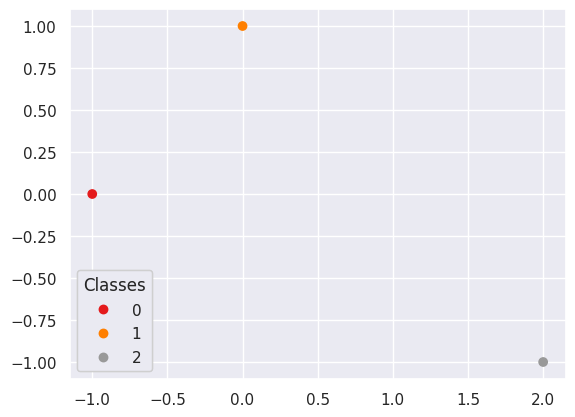

In [7]:
fig, ax = plt.subplots()
scatter = ax.scatter(data.to_numpy()[:,0], data.to_numpy()[:,1], c=labels, cmap='Set1');
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1);
plt.savefig(image_folder / 'data_plot.pdf', format='pdf')

In [8]:
# parameters

dtrain = xgb.DMatrix(data, label=labels)
num_round = 1
num_labels = len(labels)

max_depth = 2
eta = .5

param = {'max_depth': max_depth, 'eta': eta, 'objective': 'multi:softprob', "num_class": num_labels}
param['min_child_weight'] = 0
param['nthread'] = 4
param['eval_metric'] = 'mlogloss'

evallist_small = [(dtrain, 'train')]

In [9]:
import numpy as np


def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))


def softprob_obj(data, labels, prev_pred, weights=None):
    '''Loss function.  Computing the gradient and approximated hessian (diagonal).
    Reimplements the `multi:softprob` inside XGBoost.
    '''

    # The prediction is of shape (rows, classes), each element in a row
    # represents a raw prediction (leaf weight, hasn't gone through softmax
    # yet).  In XGBoost 1.0.0, the prediction is transformed by a softmax
    # function, fixed in later versions.
    
    kRows    = prev_pred.shape[0]
    kClasses = prev_pred.shape[1]
    
    grad = np.zeros((kRows, kClasses), dtype=float)
    hess = np.zeros((kRows, kClasses), dtype=float)

    eps = 1e-6

    # compute the gradient and hessian, slow iterations in Python, only
    # suitable for demo.  Also the one in native XGBoost core is more robust to
    # numeric overflow as we don't do anything to mitigate the `exp` in
    # `softmax` here.
    for r in range(kRows):
        target = labels[r]
        #p = softmax(prev_pred[r, :]) # no softmax!!
        p = prev_pred[r, :]
        for c in range(kClasses):
            #assert target >= 0 or target <= kClasses
            g = p[c] - 1.0 if c == target else p[c]
            h = max((2.0 * p[c] * (1.0 - p[c])).item(), eps)
            grad[r, c] = g
            hess[r, c] = h
    
    if weights is not None:
        grad = grad*weights
        hess = hess*weights
        
    # Right now (XGBoost 1.0.0), reshaping is necessary
    # grad = grad.reshape((kRows * kClasses, 1))
    # hess = hess.reshape((kRows * kClasses, 1))
    return grad, hess

In [10]:
#prev_pred = np.array([[1/len(labels) for _ in range(len(labels))] for _ in range(len(data))])
prev_pred = np.array([np.array([1/2,1/4,1/4]),np.array([1/3,1/3,1/3]),np.array([1/2,1/6,1/3])])
grad, hess = softprob_obj(data, labels, prev_pred)

In [11]:
prev_pred

array([[0.5       , 0.25      , 0.25      ],
       [0.33333333, 0.33333333, 0.33333333],
       [0.5       , 0.16666667, 0.33333333]])

In [12]:
print(grad)
print(hess)

[[-0.5         0.25        0.25      ]
 [ 0.33333333 -0.66666667  0.33333333]
 [ 0.5         0.16666667 -0.66666667]]
[[0.5        0.375      0.375     ]
 [0.44444444 0.44444444 0.44444444]
 [0.5        0.27777778 0.44444444]]


In [13]:
first_tree = BinaryDecisionTree(class_label=0, num_features=2, params=param)
first_tree.fit(data, labels, prev_pred)

second_tree = BinaryDecisionTree(class_label=1, num_features=2, params=param)
second_tree.fit(data, labels, prev_pred)

third_tree = BinaryDecisionTree(class_label=2, num_features=2, params=param)
third_tree.fit(data, labels, prev_pred)

Term:  0.16666666666666666
Term:  0.3571428571428571
Term:  0.04545454545454545
0 1
-0.5 0.8333333333333333 0.5 0.9444444444444444
0.47835497835497826
Term:  0.014285714285714289
Term:  0.16666666666666666
Term:  0.04545454545454545
0 2
-0.16666666666666669 0.5 0.9444444444444444 0.5
0.1354978354978355
Term:  0.16666666666666666
Term:  0.014285714285714289
Term:  0.04545454545454545
1 1
0.5 -0.16666666666666669 0.5 0.9444444444444444
0.1354978354978355
Term:  0.0
Term:  0.07692307692307691
Term:  0.04545454545454545
1 2
0.0 0.3333333333333333 1.0 0.4444444444444444
0.031468531468531465
Term:  0.07692307692307691
Term:  0.16666666666666663
Term:  0.3571428571428571
0 1
0.3333333333333333 0.49999999999999994 0.4444444444444445 0.49999999999999994
-0.11355311355311354
Term:  0.16666666666666666
Term:  0.07692307692307689
Term:  0.3571428571428571
1 1
0.5 0.33333333333333326 0.5 0.4444444444444444
-0.11355311355311354
Term:  0.045454545454545456
Term:  0.1451612903225807
Term:  0.029801324

In [14]:
first_tree.tree_to_dataframe()

,Node,Feature,Split,Gain,Base Weight,Cover,Default left,node_id,parent
0,0,0,-0.500000,0.478355,-0.136364,1.444444,1,0,2147483647
1,1,0,0.166667,0.166667,0.333333,0.500000,0,1,0
2,2,0,-0.214286,-0.214286,-0.428571,0.944444,0,2,0


In [15]:
second_tree.tree_to_dataframe()

,Node,Feature,Split,Gain,Base Weight,Cover,Default left,node_id,parent
0,0,1,0.500000,0.382933,0.119205,1.097222,1,0,2147483647
1,1,0,-0.126050,-0.126050,-0.252101,0.652778,0,1,0
2,2,0,0.230769,0.230769,0.461538,0.444444,0,2,0


In [16]:
third_tree.tree_to_dataframe()

,Node,Feature,Split,Gain,Base Weight,Cover,Default left,node_id,parent
0,0,0,1.000000,0.491648,0.036810,1.263889,1,0,2147483647
1,1,0,-0.160305,-0.160305,-0.320611,0.819444,0,1,0
2,2,0,0.230769,0.230769,0.461538,0.444444,0,2,0


In [19]:
test = first_tree.to_xgboost_dict()
test['id']=1
print(test)

{'base_weights': [-0.13636364, 0.33333333, -0.42857143], 'categories': [], 'categories_nodes': [], 'categories_segments': [], 'categories_sizes': [], 'default_left': [1, 0, 0], 'id': 1, 'left_children': [1, -1, -1], 'loss_changes': [0.47835498, 0.0, 0.0], 'parents': [2147483647, 0, 0], 'right_children': [2, -1, -1], 'split_conditions': [-0.5, 0.16666667, -0.21428571], 'split_indices': [0, 0, 0], 'split_type': [0, 0, 0], 'sum_hessian': [1.44444444, 0.5, 0.94444444], 'tree_param': {'num_deleted': '0', 'num_feature': '2', 'num_nodes': '3', 'size_leaf_vector': '0'}}


In [20]:
first_tree_dict = first_tree.to_xgboost_dict()
second_tree_dict = second_tree.to_xgboost_dict()
second_tree_dict['id'] = 1
third_tree_dict = third_tree.to_xgboost_dict()
third_tree_dict['id'] = 2

example_model = {"learner":{"attributes":{"best_iteration":"0","best_ntree_limit":"1"},"feature_names":["Feature1","Feature2"],"feature_types":["int","int"],"gradient_booster":{"model":{"gbtree_model_param":{"num_parallel_tree":"1","num_trees":"3","size_leaf_vector":"0"},"tree_info":[0,1,2],"trees":[first_tree_dict,  second_tree_dict, third_tree_dict]},"name":"gbtree"},"learner_model_param":{"base_score":"5E-1","boost_from_average":"1","num_class":"3","num_feature":"2","num_target":"1"},"objective":{"name":"multi:softprob","softmax_multiclass_param":{"num_class":"3"}}},"version":[1,7,3]}

with open('example_model_json.json', 'w', encoding='utf-8') as f:
    json.dump(example_model, f, separators=(',', ':'))
    f.close()

In [21]:
example_bst = xgb.Booster()
example_bst.load_model('example_model_json.json')

In [22]:
example_bst.save_model('sanity_check.json')

In [23]:
print("Accuracy on test data: ", skl.metrics.accuracy_score(np.argmax(example_bst.predict(dtrain), axis=1), labels))

Accuracy on test data:  1.0


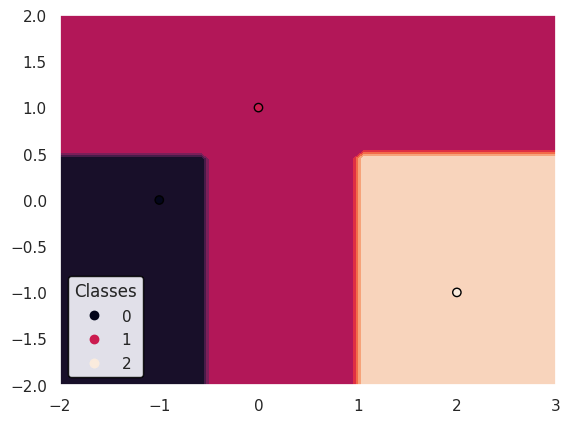

In [43]:
plot_decision_boundaries(data,labels,example_bst)

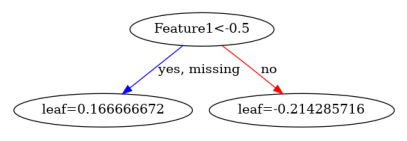

In [33]:
xgb.plot_tree(example_bst, num_trees=0)
plt.gcf().set_size_inches(5, 3)
plt.savefig(image_folder / 'first_tree_plot.pdf', format='pdf');
plt.show();

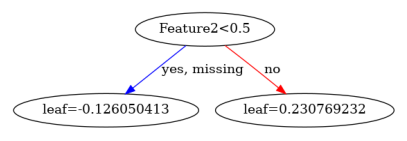

In [34]:
xgb.plot_tree(example_bst, num_trees=1)
plt.gcf().set_size_inches(5, 3)
plt.savefig(image_folder / 'second_tree_plot.pdf', format='pdf')
plt.show();

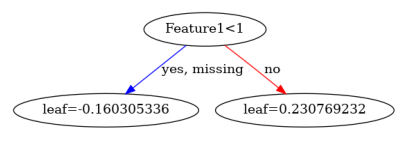

In [35]:
xgb.plot_tree(example_bst, num_trees=2)
plt.gcf().set_size_inches(5, 3)
plt.savefig(image_folder / 'third_tree_plot.pdf', format='pdf');
plt.show();